# How to run CorrHOD_cutsky

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from pycorr import project_to_multipoles

from CorrHOD import CorrHOD_cutsky

# Get the number of threads available
import multiprocessing
nthread = multiprocessing.cpu_count()
print(f'Number of threads available: {nthread}')

Number of threads available: 256


In [3]:
# Logging
import sys
from CorrHOD import create_logger
from mockfactory import setup_logging

# Get a logger object
setup_logging() # Initialize the logging for all the loggers that will not have a handler 
logger = create_logger('CorrHOD', level='debug', stream=sys.stdout)

In [4]:
# Define the parameters we will use
path2config = Path('config.yaml') # Useless here, but we need it to create the object

# DensitySplit parameters
nquantiles = 10 # Number of quantiles to split the sample

# Correlation functions parameters
sbins = np.linspace(0.1, 30, 50) # Bins in s for the CFs (default ones)
edges = [sbins, np.linspace(-1, 1, 60)]

At this point in developpement, the simulation generation is not implemented yet. Here is how to load one in the class to run the analysis :

In [5]:
from CorrHOD.catalogs import read_fits, catalog_cuts, create_random

# Read the data
path = '/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/BGS_v2/z0.200/cutsky_BGS_z0.200_AbacusSummit_base_c000_ph000.fits'
data_cutsky = read_fits(path, check_cutsky_format=True, print_column_names=True)

# Apply some cuts to the data
zcut = [0.1, 0.5]
magcut = -21.5 # Magnitude cut : We only keep galaxies brighter than this magnitude (i.e. with a lower magnitude)
data_cutsky = catalog_cuts(data_cutsky, zmin=zcut[0], zmax=zcut[1], abs_mag=magcut, app_mag=None, cap='NGC')

# Import the randoms (Same thing as the data)
path = '/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/BGS_v2/z0.200'
randoms_cutsky = create_random(path, multiplier=3) 
randoms_cutsky = catalog_cuts(randoms_cutsky, zmin=zcut[0], zmax=zcut[1], abs_mag=magcut, app_mag=None, cap='NGC')

The columns of the dataframe are : ['R_MAG_APP' 'R_MAG_ABS' 'G_R_REST' 'G_R_OBS' 'DEC' 'HALO_MASS' 'CEN'
 'RES' 'RA' 'Z_COSMO' 'Z' 'STATUS' 'NGC' 'SGC']


In [6]:
# Create the CorrHOD object
Object = CorrHOD_cutsky(path2config) 
Object.cutsky_dict = data_cutsky
Object.randoms_dict = randoms_cutsky

In [19]:
data_positions, randoms_positions = Object.get_tracer_positions(return_cartesian=True) # Get the positions of the tracers and get the coordinates in the right shift
Object.get_tracer_weights();  # Get the weights of the tracers

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20230712-1.0.0/conda/lib/python3.10/site-packages/CorrHOD/cutsky.py:70: UserWarning: The object is not a hod_dict. Trying to load it as a positional dataset.
  warn('The object is not a hod_dict. Trying to load it as a positional dataset.', UserWarning)


Sky fraction : 24.49%


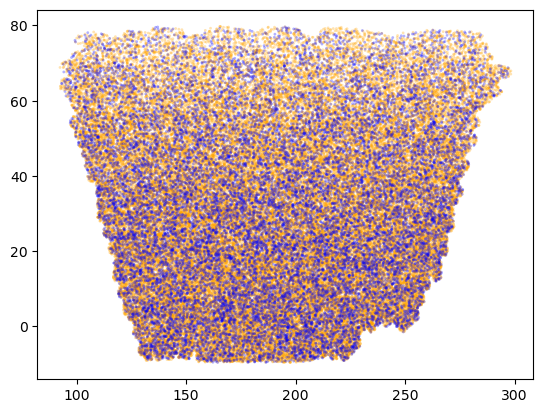

In [14]:
# Get the sky fraction and footprint

from CorrHOD.weights import sky_fraction, comoving_volume
from cosmoprimo.fiducial import AbacusSummit
cosmo = AbacusSummit('000')

# Compute the sky fraction
ra = np.asarray(randoms_cutsky['RA'])
dec = np.asarray(randoms_cutsky['DEC'])
fsky = sky_fraction(ra, dec)
area = fsky*4*np.pi*(180/np.pi)**2

print(f"Sky fraction : {fsky:.2%}")

nsub=50 # Subsampling factor to avoid plotting too much points
plt.scatter(randoms_cutsky['RA'][::nsub], randoms_cutsky['DEC'][::nsub], s=1, alpha=0.3, facecolors='none', edgecolors='orange')
plt.scatter(data_cutsky['RA'][::nsub], data_cutsky['DEC'][::nsub], s=1, alpha=0.3, facecolors='none', edgecolors='b'); # Plot the data after the randoms because there are less points

In [15]:
# Compute the DensitySplit
quantiles, density = Object.compute_DensitySplit(nquantiles=nquantiles, return_density=True, nthread=nthread);

[000307.47] [0/1] 07-13 14:18  FFTWEngine                INFO     Saving wisdom to wisdom.shape-344-533-333.type-float64.nthreads-256.npy.
[000308.92] [0/1] 07-13 14:18  FFTWEngine                INFO     Loading wisdom from wisdom.shape-344-533-333.type-float64.nthreads-256.npy.
[000309.00] [0/1] 07-13 14:18  FFTWEngine                INFO     Saving wisdom to wisdom.shape-344-533-333.type-float64.nthreads-256.npy.


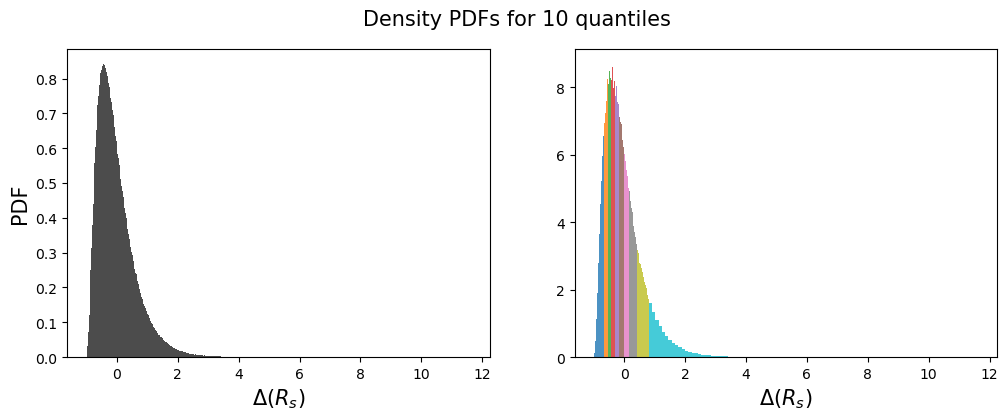

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plot the quantiles density
from pandas import qcut
density_quantiles = []
q_cut = qcut(density, nquantiles, labels=False) 

for i in range(nquantiles):
    density_quantiles.append(density[q_cut == i])
    ax[1].hist(density_quantiles[i], bins=100, density=True, alpha=0.8, label=f'Q{i}')

ax[0].hist(density, bins=500, density=True, alpha=0.7, color='k')

ax[0].set_xlabel(r'$\Delta(R_s)$', fontsize=15)
ax[1].set_xlabel(r'$\Delta(R_s)$', fontsize=15)
ax[0].set_ylabel('PDF', fontsize=15)
fig.suptitle(f'Density PDFs for {nquantiles} quantiles', fontsize=15);

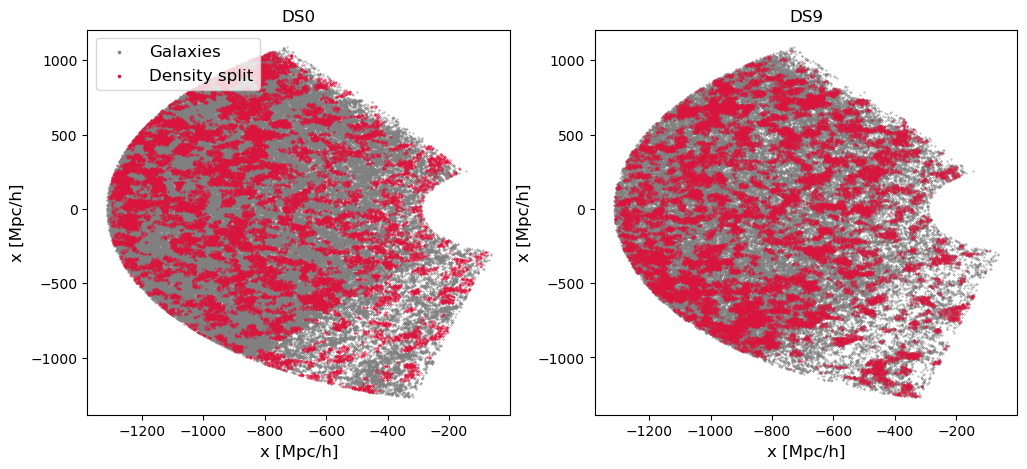

In [24]:
# Plot the positions in the sky
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# boxsize = 2000

cut = data_positions[:, 2] < 50
ax[0].scatter(data_positions[cut, 0], data_positions[cut, 1], s=0.1, color='grey', label='Galaxies')
ax[1].scatter(data_positions[cut, 0], data_positions[cut, 1], s=0.1, color='grey', label='Galaxies')

# Get the cartesian quantiles
cquantiles = Object.quantiles_cartesian

for i, ids in enumerate([0, nquantiles-1]):
    cut = cquantiles[ids][:, 2] < 50
    
    ax[i].scatter(cquantiles[ids][cut, 0], cquantiles[ids][cut, 1], s=0.1, color='crimson', label='Density split')
    ax[i].set_title(f'DS{ids}', fontsize=12)

    ax[i].set_xlabel('x [Mpc/h]', fontsize=12)
    ax[i].set_ylabel('x [Mpc/h]', fontsize=12)
#     ax[i].set_xlim(0, boxsize)
#     ax[i].set_ylim(0, boxsize)

ax[0].legend(fontsize=12, markerscale=5, loc='upper left')
plt.show();

In [25]:
Object.get_tracer_weights(); # Get the weights for the quantiles (now that we have them)

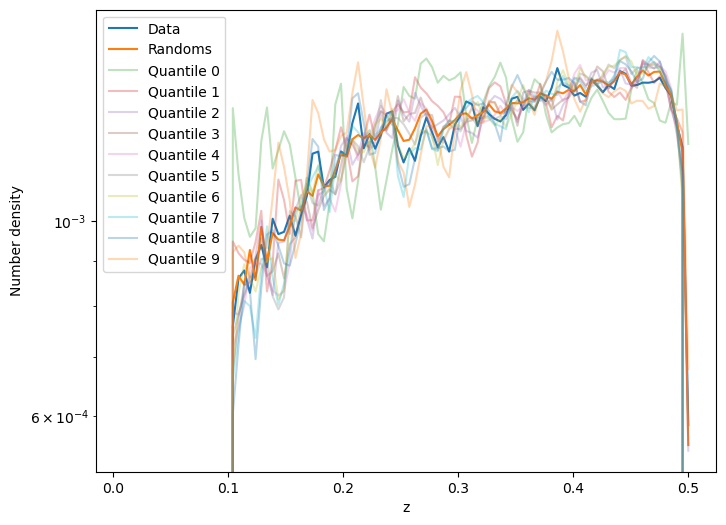

In [26]:
# Get and plot the n(z) of the data, randoms and quantiles
nz_data, nz_randoms, nz_quantiles = Object.get_nz()

fig, ax = plt.subplots(figsize=(8, 6))
z_space = np.linspace(0.01, 0.5, 100)

ax.plot(z_space, nz_data(z_space)*3, label='Data') # Note the factor 3 here, because we have 3 times more randoms than data
ax.plot(z_space, nz_randoms(z_space), label='Randoms')

for i in range(nquantiles):
    ax.plot(z_space, nz_quantiles[i](z_space)*10, label=f'Quantile {i}', alpha=0.3) # Same here, the quantiles are by definition 10 times less than the randoms

ax.legend()
ax.set_xlabel('z')
ax.set_ylabel('Number density')
ax.set_yscale('log')

In [27]:
# Downsample the data
npoints = 3_000_000 # Number of points to use for the downsampling
Object.downsample_data(npoints=npoints);

Data not downsampled due to number density 1.31e-03 (3000000 points) too small or None


[000796.30] [0/1] 07-13 14:26  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000796.31] [0/1] 07-13 14:26  TwoPointCorrelationFunction INFO     Running auto-correlation.
[000796.31] [0/1] 07-13 14:26  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
[000799.87] [0/1] 07-13 14:26  TwoPointCorrelationFunction INFO     Computing two-point counts D1R2.
[000810.59] [0/1] 07-13 14:27  TwoPointCorrelationFunction INFO     Computing two-point counts R1R2.


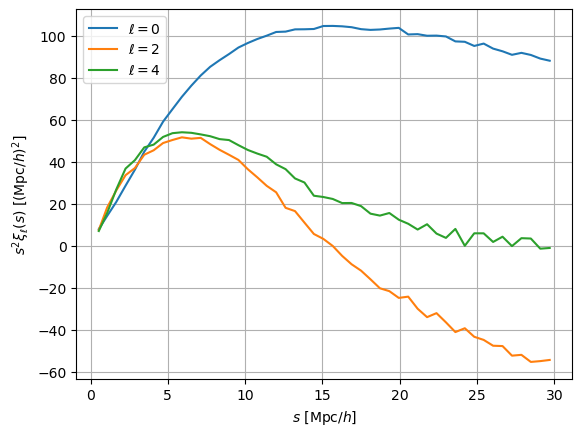

In [28]:
# Compute the 2PCF
xi = Object.compute_2pcf(edges=edges, nthread=nthread)

xi.plot(mode='poles'); # Quick way to plot the CFs from pycorr

In [ ]:
# Compute the Cross-Correlation for DS0 and DS9
xi_0 = Object.compute_cross_corr(0, edges=edges, nthread=nthread)
xi_9 = Object.compute_cross_corr(nquantiles-1, edges=edges, nthread=nthread)